In [1]:
import numpy as np
import pandas as pd

C:\Users\hrith\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\hrith\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\hrith\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
df=pd.read_csv('./dataset/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
df['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

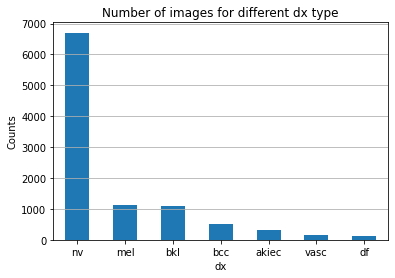

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
df['dx'].value_counts().plot.bar(rot=0)
plt.title('Number of images for different dx type')
plt.xlabel('dx')
plt.ylabel('Counts')
plt.grid(axis='y')

In [5]:
# Creating 'num_images' to record the number of images belonging to the same 'lesion_id'
# Creating 'dx_id' convert the 'dx' to integer label
# Creating 'image_path' to store the path to access the image
# Creating 'images' to store the resized image as arrays

from os.path import isfile
from PIL import Image as pil_image
df['num_images'] = df.groupby('lesion_id')["image_id"].transform("count")

classes = df['dx'].unique()
labeldict = {}
for num, name in enumerate(classes):
    labeldict[name] = num
df['dx_id'] = df['dx'].map(lambda x: labeldict[x])


def expand_path(p):
    if isfile('./dataset/Images/' + p + '.jpg'): return './dataset/Images/' + p + '.jpg'
    return p 
df['image_path'] = df['image_id']
df['image_path'] = df['image_path'].apply(expand_path)


df['images'] = df['image_path'].map(lambda x: np.asarray(pil_image.open(x).resize((150,112))))
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,num_images,dx_id,image_path,images
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,0,./dataset/Images/ISIC_0027419.jpg,"[[[190, 153, 196], [193, 156, 197], [192, 155,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,0,./dataset/Images/ISIC_0025030.jpg,"[[[25, 12, 21], [25, 14, 18], [25, 15, 26], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,0,./dataset/Images/ISIC_0026769.jpg,"[[[187, 125, 136], [189, 133, 142], [194, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,0,./dataset/Images/ISIC_0025661.jpg,"[[[23, 12, 18], [24, 11, 20], [30, 14, 25], [3..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,0,./dataset/Images/ISIC_0031633.jpg,"[[[128, 89, 110], [141, 96, 119], [149, 104, 1..."


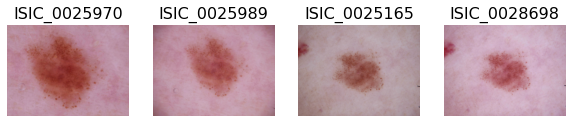

In [6]:
def plot_images(imgs, labels, cols=4):
    # Setting figure to 13 inches x 8 inches
    figure = plt.figure(figsize=(10, 7))

    rows = len(imgs) // cols + 1

    for i in range(len(imgs)):
        img = plt.imread(expand_path(imgs[i]))
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        if labels:
            subplot.set_title(labels[i], fontsize=16)
        plt.imshow(img, cmap='gray')        

images = df[df['lesion_id'] == 'HAM_0003033'].image_id

plot_images(list(images),list(images))

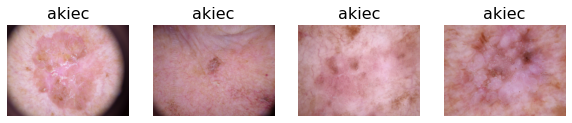

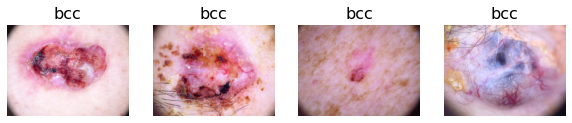

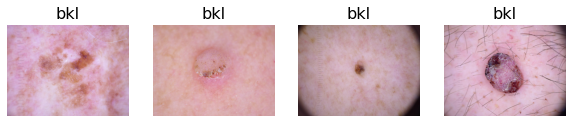

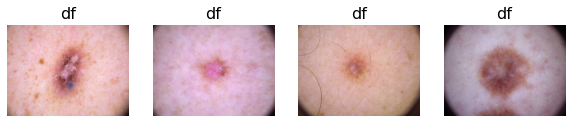

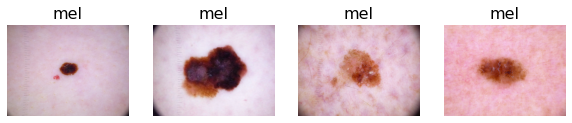

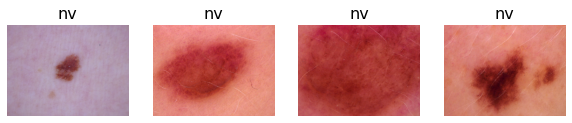

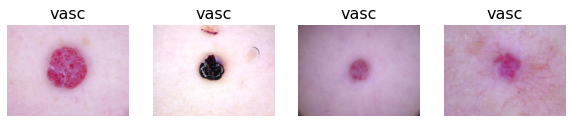

In [7]:
# Images belonging to the seven different types
imgdict = {'akiec':list(df[df['dx']=='akiec']['image_id'])[0:24:6],'bcc':list(df[df['dx']=='bcc']['image_id'])[0:24:6],\
        'bkl':list(df[df['dx']=='bkl']['image_id'])[0:24:6],'df':list(df[df['dx']=='df']['image_id'])[0:24:6],\
        'mel':list(df[df['dx']=='mel']['image_id'])[0:24:6],'nv':list(df[df['dx']=='nv']['image_id'])[0:24:6],\
        'vasc':list(df[df['dx']=='vasc']['image_id'])[0:24:6]}

for i in np.arange(7):
    cancertype = list(imgdict.keys())[i]
    cancertypetolist = [cancertype,cancertype,cancertype,cancertype]
    plot_images(list(imgdict.values())[i],cancertypetolist)

In [8]:
# Splitting the dataframe and creating train, test and validation images and labels
from sklearn.model_selection import train_test_split

# selecting the testset and validationset from the lesion_id with only one corresponding image_id. 
# as these images have no similar sibling images

df_single = df[df['num_images'] == 1]
trainset1, testset = train_test_split(df_single, test_size=0.2,random_state = 700)
trainset2, validationset = train_test_split(trainset1, test_size=0.2,random_state = 234)
trainset3 = df[df['num_images'] != 1]
frames = [trainset2, trainset3]
trainset = pd.concat(frames)

def prepareimages(images):
    # images is a list of images
    images = np.asarray(images).astype(np.float64)
    images = images[:, :, :, ::-1]
    m0 = np.mean(images[:, :, :, 0])
    m1 = np.mean(images[:, :, :, 1])
    m2 = np.mean(images[:, :, :, 2])
    images[:, :, :, 0] -= m0
    images[:, :, :, 1] -= m1
    images[:, :, :, 2] -= m2
    return images
trainimages = prepareimages(list(trainset['images']))
testimages = prepareimages(list(testset['images']))
validationimages = prepareimages(list(validationset['images']))
trainlabels = np.asarray(trainset['dx_id'])
testlabels = np.asarray(testset['dx_id'])
validationlabels = np.asarray(validationset['dx_id'])
print(np.shape(trainimages))
print(np.shape(testimages))
print(np.shape(validationimages))

(8029, 112, 150, 3)
(1103, 112, 150, 3)
(883, 112, 150, 3)


In [9]:
# Data Augmentation
# It includes rotation, zoom, shift in two directions
from keras.preprocessing.image import ImageDataGenerator

trainimages = trainimages.reshape(trainimages.shape[0], *(112, 150, 3))

data_gen = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True, 
        vertical_flip=True)

data_gen.fit(trainimages)

Using TensorFlow backend.
C:\Users\hrith\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hrith\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hrith\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hrith\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [10]:
#Building CNN model - ResNet50
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from keras import regularizers

input_shape = (112, 150, 3)

num_labels = 7

base_model = ResNet50(include_top=False, input_shape=(112, 150, 3),pooling = 'avg', weights = 'imagenet')

model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02)))

for layer in base_model.layers:
    layer.trainable = True

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 23,850,887
Trainable params: 23,797,767
Non-trainable params: 53,120
_____________________________________________________

In [11]:
from tensorflow.python.keras.optimizers import Adam
optimizer = Adam (lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=5e-7, amsgrad=False)
model.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [12]:
import keras
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
class CustomModelCheckPoint(keras.callbacks.Callback):
    def __init__(self,**kargs):
        super(CustomModelCheckPoint,self).__init__(**kargs)
        self.epoch_accuracy = {} # loss at given epoch
        self.epoch_loss = {} # accuracy at given epoch
        def on_epoch_begin(self,epoch, logs={}):
            # Things done on beginning of epoch. 
            return

        def on_epoch_end(self, epoch, logs={}):
            # things done on end of the epoch
            self.epoch_accuracy[epoch] = logs.get("acc")
            self.epoch_loss[epoch] = logs.get("loss")
            self.model.save_weights("name-of-model-%d.h5" %epoch)
            
checkpoint = CustomModelCheckPoint()
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 3)
cb_checkpointer = ModelCheckpoint(filepath = 'best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')
epochs = 5
batch_size = 50
trainhistory = model.fit_generator(data_gen.flow(trainimages,trainlabels, batch_size=batch_size),
                              epochs = epochs, validation_data = (validationimages,validationlabels),
                              verbose = 1, steps_per_epoch=trainimages.shape[0] // batch_size,
                                       callbacks=[cb_checkpointer, cb_early_stopper])


Epoch 1/5
160/160 [==============================] - 3642s 23s/step - loss: 4.0370 - acc: 0.6749 - val_loss: 2.1308 - val_acc: 0.8709
Epoch 2/5
160/160 [==============================] - 3372s 21s/step - loss: 1.6913 - acc: 0.7369 - val_loss: 1.0935 - val_acc: 0.8313
Epoch 3/5
160/160 [==============================] - 3405s 21s/step - loss: 1.0658 - acc: 0.7626 - val_loss: 0.6423 - val_acc: 0.8732
Epoch 4/5
160/160 [==============================] - 4219s 26s/step - loss: 0.8706 - acc: 0.7683 - val_loss: 0.6166 - val_acc: 0.8652
Epoch 5/5
160/160 [==============================] - 4108s 26s/step - loss: 0.7926 - acc: 0.7753 - val_loss: 0.7537 - val_acc: 0.8256


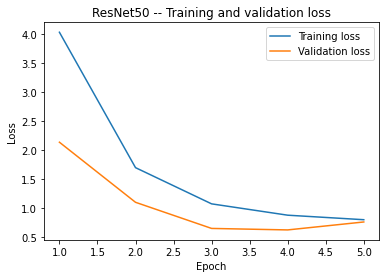

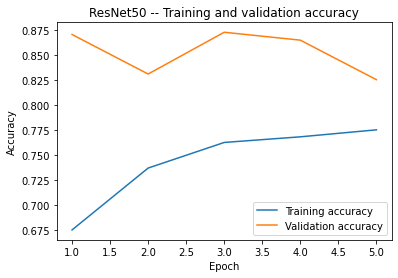

In [13]:
acc = trainhistory.history['acc']
val_acc = trainhistory.history['val_acc']
loss = trainhistory.history['loss']
val_loss = trainhistory.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, '', label='Training loss')
plt.plot(epochs, val_loss, '', label='Validation loss')
plt.title('ResNet50 -- Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, '', label='Training accuracy')
plt.plot(epochs, val_acc, '', label='Validation accuracy')
plt.title('ResNet50 -- Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [14]:
train_loss, train_acc = model.evaluate(trainimages,trainlabels, verbose=1)
test_loss, test_acc = model.evaluate(testimages,testlabels, verbose=1)

print("Train: accuracy = %f  ;  loss = %f" % (train_acc, train_loss))
print("Test: accuracy = %f  ;  loss = %f" % (test_acc, test_loss))

1103/1103 [==============================] - 40s 37ms/sample - loss: 0.7007 - acc: 0.8350
Train: accuracy = 0.698717  ;  loss = 1.163043
Test: accuracy = 0.834995  ;  loss = 0.700733


In [15]:
test_loss, test_acc = model.evaluate(testimages,testlabels, verbose=1)

print("Test: accuracy = %f  ;  loss = %f" % (test_acc, test_loss))

1103/1103 [==============================] - 34s 31ms/sample - loss: 0.7007 - acc: 0.8350
Test: accuracy = 0.834995  ;  loss = 0.700733


In [16]:
from sklearn.metrics import confusion_matrix
train_pred = model.predict(trainimages)
train_pred_classes = np.argmax(train_pred,axis = 1)
test_pred = model.predict(testimages)
# Convert predictions classes to one hot vectors 
test_pred_classes = np.argmax(test_pred,axis = 1) 

confusionmatrix = confusion_matrix(testlabels, test_pred_classes)
confusionmatrix

array([[ 17,  69,   0,   0,   1,   0,   0],
       [  3, 880,   0,   0,   3,   0,   0],
       [  0,   7,   0,   0,   0,   1,   0],
       [  5,  30,   0,   0,   0,   1,   0],
       [  0,   1,   0,   0,  13,   0,   0],
       [  4,  23,   0,   0,   2,  11,   0],
       [  5,  24,   0,   0,   0,   3,   0]], dtype=int64)

In [17]:
from sklearn.metrics import classification_report
labels = labeldict.keys()
# Generate a classification report
#trainreport = classification_report(trainlabels, train_pred_classes, target_names=list(labels))
testreport = classification_report(testlabels, test_pred_classes, target_names=list(labels))
#print(trainreport)
print(testreport)

              precision    recall  f1-score   support

         bkl       0.50      0.20      0.28        87
          nv       0.85      0.99      0.92       886
          df       0.00      0.00      0.00         8
         mel       0.00      0.00      0.00        36
        vasc       0.68      0.93      0.79        14
         bcc       0.69      0.28      0.39        40
       akiec       0.00      0.00      0.00        32

    accuracy                           0.83      1103
   macro avg       0.39      0.34      0.34      1103
weighted avg       0.76      0.83      0.78      1103



C:\Users\hrith\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
#save the model 
model.save('model-final-resnet.h5')